In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy import constants as cst
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
from numpy import interp
from scipy.integrate import trapezoid as trap
import seaborn as sns

# matplotlib globals
plt.rc('font',   size=16)          # controls default text sizes
plt.rc('axes',   titlesize=18)     # fontsize of the axes title
plt.rc('axes',   labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick',  labelsize=18)     # fontsize of the tick labels
plt.rc('ytick',  labelsize=18)     # fontsize of the tick labels
plt.rc('legend', fontsize=18)      # legend fontsize
plt.rc('figure', titlesize=18)     # fontsize of the figure title

## Auxiliary

In [2]:
def chirp(m1, m2):
    return (m1*m2)**(3/5) / (m1+m2)**(1/5)

def WD_radius(m):
    # Eggleton 1986 fit to Nauenberg for high m and ZS for low m. From 
    r = 0.0114*np.sqrt( (m/1.44)**(-2/3) - (m/1.44)**(2/3) ) * (1 + 3.5*(m/0.00057)**(-2/3) + 0.00057/m)**(-2/3)
    return r # solar radii

def a_min(m1, m2):
    # assume m2 < m1
    r1 = WD_radius(m1)
    r2 = WD_radius(m2)
    q = m2/m1
    ap_min = r1*(0.6 + q**(2/3) * np.log(1 + q**(-1/3)))/0.49
    as_min = r2*(0.6 + q**(-2/3) * np.log(1 + q**(1/3)))/0.49
    return max(ap_min, as_min) # in solar radii

def Kepler(m1, m2):
    nu = np.sqrt(cst.G * cst.M_sun*(m1+m2)/(4*np.pi**2*(a_min(m1, m2)* cst.R_sun)**3))
    return nu.value # Hz

def chirp(m1, m2):
    return (m1*m2)**(3/5) / (m1+m2)**(1/5)

def determine_nu_crit(m1, m2, time = 13.8):
    K = (96/5) * (2*np.pi)**(8/3) * (cst.G * chirp(m1,m2)*cst.M_sun)**(5/3) / cst.c**5
    return ((Kepler(m1, m2))**(-8/3) + 8*K.value*(time* 10**9 * 365.25 * 24 * 3600)/3)**(-3/8)

def K(M):
    return (96/5) * (2*np.pi)**(8/3) * (cst.G * M*cst.M_sun)**(5/3) / cst.c**5

def timespan(nu_1, nu_2, M, K):
    return 3*(nu_1**(-8/3) - nu_2**(-8/3))/(8*K)

def SFH(z):
    return 0.015*(1+z)**(2.7)/(1+((1+z)/2.9)**(5.6))  # solar mass / yr / Mpc^3 [Madau, Dickinson 2014]


# Paper

## Time integration

First create an array of z bins corresponding to equally spaced time intervals.

In [3]:
T0 = cosmo.lookback_time(8)
N_t = 20
T_range = np.linspace(0, T0.value, 2*N_t+1)

T_list = np.array([T_range[2*i+1] for i in range(N_t)])
T_bins = np.array([T_range[2*i] for i in range(N_t+1)])

dT = (T_list[1] - T_list[0])

z_list = []
z_bins = []
for time in T_list:
    z_list.append(z_at_value(cosmo.lookback_time, time * u.Gyr).value)
for time in T_bins[1:]:
    z_bins.append(z_at_value(cosmo.lookback_time, time * u.Gyr).value)

z_bins[1::2]


[0.09758672307007864,
 0.21091904631006503,
 0.3452407606933971,
 0.5087529585432726,
 0.7150816948999171,
 0.9887695004832725,
 1.379361867336969,
 2.0060292692907256,
 3.2599403089559402,
 8.00000002576731]

### Stacked bar chart: Equal time bins

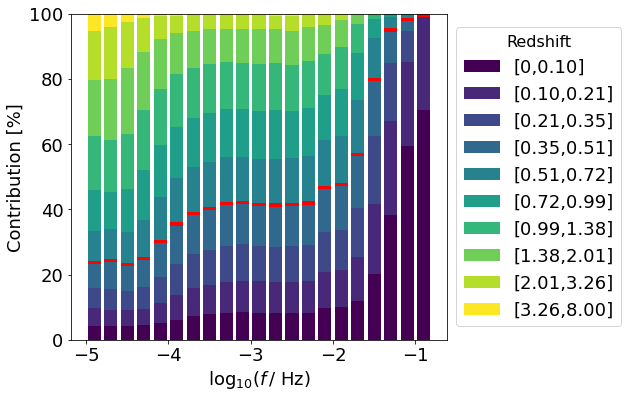

In [4]:
SFH = 1
N = 25
N_t = 20
SAVE = True

data1 = pd.read_csv(f"../Output/GWBs/SFH{SFH}_corr_{N}_{N_t}_T_contr.txt", sep = ",")
data2 = pd.read_csv(f"../Output/GWBs/SFH{SFH}_corr_{N}_{N_t}_T_contr_birth.txt", sep = ",")
data3 = pd.read_csv(f"../Output/GWBs/SFH{SFH}_corr_{N}_{N_t}_T_contr_merge.txt", sep = ",")


f_range = np.logspace(-5, 0, 2*N+1, base = 10)
f_plot = np.log10(np.array([f_range[2*i+1] for i in range(N)]))
z_list = data1.z
colors = plt.cm.get_cmap('viridis', N_t//2)
new_data = pd.DataFrame({"z":z_list})

# Calculate the percentage contribution of the redshift bins
for i in range(N):
    new_data[f"prop_f_{i}"] = 99* (data1[f"freq_{i}"]+data2[f"freq_{i}"]+data3[f"freq_{i}"]) / (data1[f"freq_{i}"].sum()+data2[f"freq_{i}"].sum()+data3[f"freq_{i}"].sum())
new_data.drop("z", inplace=True, axis = 1)


fig, ax = plt.subplots(1, 1, figsize = (9,6))

if N == 25:

    width = (f_plot[2]-f_plot[1])

    ax.bar(f_plot, new_data.iloc[0] + new_data.iloc[1], 
        color = colors(0), label = f"[0,{z_bins[1]:.2f}]", width=0.8*width)
    sum = new_data.iloc[0] + new_data.iloc[1]

elif N==50:

    width = 2*(f_plot[2]-f_plot[1])

    ax.bar(f_plot[::2], new_data.iloc[0].values[::2] + new_data.iloc[1].values[::2], 
        color = colors(0), label = f"[0,{z_bins[1]:.2f}]", width=0.8*width)
    sum = new_data.iloc[0].values[::2] + new_data.iloc[1].values[::2]

else:
    print(f"Not correctly implemented yet for N = {N}.")

draw_line = False
prev_z_bin = z_bins[1]

for i, z in enumerate(z_bins[3::2]):

    if N == 25:
        props = new_data.iloc[2*i+2] + new_data.iloc[2*i+3]
        ax.bar(f_plot, props, bottom=sum, color = colors(i+1), label = f"[{prev_z_bin:.2f},{z:.2f}]", width=0.8*width)

    elif N == 50:
        props = new_data.iloc[2*i+2].values[::2] + new_data.iloc[2*i+3].values[::2]
        ax.bar(f_plot[::2], props, bottom=sum, color = colors(i+1), label = f"[{prev_z_bin:.2f},{z:.2f}]", width=0.8*width)
    
    else: 
        break

    sum = sum + props
    prev_z_bin = z
    if (z >= 0.46) and draw_line == False:
        draw_line = True

        if N == 25:
            ax.bar(f_plot, np.ones_like(props), bottom=sum, color = "red", width=0.8*width)
        elif N == 25:
            ax.bar(f_plot[::2], np.ones_like(props), bottom=sum, color = "red", width=0.8*width)

        sum = sum + np.ones_like(props)



ax.set_xlabel(r"$\log_{10} (f \,/$ Hz)")
ax.set_ylabel("Contribution [%]")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "Redshift")

#plt.tight_layout()
# ax.set_xlim(-4.25, -0.85)

if SAVE:
    fig.savefig(f"../Output/Figures/z_contr_{N}_{N_t}_SFH{SFH}_T.png")

plt.show()


### Numbers of systems

The number of systems is determined in the main code and stored in the columns "freq_i_num". Such a column stores the number of BWDs in the corresponding frequency bin, for each z bin.

In [63]:
# The run with the cleaned code.

# tag = "net"

# data1 = pd.read_csv(f"../Output/GWBs/SFH1_25_20_z_contr_{tag}.txt")
# data2 = pd.read_csv(f"../Output/GWBs/SFH1_corr_25_20_z_contr_birth_{tag}.txt")
# data3 = pd.read_csv(f"../Output/GWBs/SFH1_corr_25_20_z_contr_merge_{tag}.txt")

tag = "adapt"
N = 100
N_z = 20

data1 = pd.read_csv(f"../Output/GWBs/SFH1_{N}_{N_z}_z_contr_{tag}.txt")
data2 = pd.read_csv(f"../Output/GWBs/SFH1_{N}_{N_z}_z_contr_birth_{tag}.txt")
data3 = pd.read_csv(f"../Output/GWBs/SFH1_{N}_{N_z}_z_contr_merge_{tag}.txt")

data1.head()



,z,freq_0,freq_0_num,freq_1,freq_1_num,freq_2,freq_2_num,freq_3,freq_3_num,freq_4,...,freq_95,freq_95_num,freq_96,freq_96_num,freq_97,freq_97_num,freq_98,freq_98_num,freq_99,freq_99_num
0,0.2,351.600171,4.018819e+14,249.290506,7.611763e+13,302.891346,1.280040e+14,370.472243,1.152413e+14,701.393521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.6,357.472747,9.697517e+14,387.848555,4.650560e+14,857.115318,9.792452e+14,737.588883,5.709610e+14,975.977524,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,444.000867,1.645964e+15,299.872826,9.007132e+14,383.296956,8.909680e+14,482.874418,1.313135e+15,948.488082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.4,135.595152,5.942377e+14,301.510905,1.133618e+15,174.414919,5.203516e+14,438.616084,1.043245e+15,507.535804,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.8,70.559529,5.494891e+14,212.807820,8.861078e+14,203.207218,7.728329e+14,323.270015,1.014213e+15,531.297047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# With 50 frequency bins. Expect larger bulk contribution.

tag = "net"

data1b = pd.read_csv(f"../Output/GWBs/SFH1_50_20_z_contr_{tag}.txt")
data2b = pd.read_csv(f"../Output/GWBs/SFH1_corr_50_20_z_contr_birth_{tag}.txt")
data3b = pd.read_csv(f"../Output/GWBs/SFH1_corr_50_20_z_contr_merge_{tag}.txt")

data1.head()


,z,freq_0,freq_0_num,freq_1,freq_1_num,freq_2,freq_2_num,freq_3,freq_3_num,freq_4,...,freq_20,freq_20_num,freq_21,freq_21_num,freq_22,freq_22_num,freq_23,freq_23_num,freq_24,freq_24_num
0,0.2,351.600171,1.075002e+15,701.393521,7.197453e+14,2153.272401,5.696519e+14,10750.443336,8.054978e+14,30401.576670,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.6,357.472747,2.594007e+15,975.977524,3.502454e+15,3651.730423,4.472337e+15,13511.271943,3.268751e+15,35652.760104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,444.000867,4.402821e+15,948.488082,4.781943e+15,3505.165609,4.643100e+15,12667.857368,5.013376e+15,28688.393868,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.4,135.595152,1.589538e+15,507.535804,2.594306e+15,3561.033465,4.004931e+15,9349.856431,5.119031e+15,19204.549207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.8,70.559529,1.469839e+15,531.297047,2.521850e+15,2119.664504,2.852762e+15,5979.984685,3.368004e+15,11306.118969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
totals1 = []
totals2 = []
totals3 = []
totals1b = []
totals2b = []
totals3b = []

N1 = 100
N2 = 50

for n in range(N1):
    totals1.append(np.sum(data1[f"freq_{n}_num"]))
    totals2.append(np.sum(data2[f"freq_{n}_num"]))
    totals3.append(np.sum(data3[f"freq_{n}_num"]))
for n in range(N2):
    totals1b.append(np.sum(data1b[f"freq_{n}_num"]))
    totals2b.append(np.sum(data2b[f"freq_{n}_num"]))
    totals3b.append(np.sum(data3b[f"freq_{n}_num"]))

print(f"{N1} bins:\n")

print(f"Total number of systems in bulk: {np.sum(np.array(totals1)):.5E}")
print(f"Total number of systems in birth bins: {np.sum(np.array(totals2)):.5E}")
print(f"Total number of systems in merge bins: {np.sum(np.array(totals3)):.5E}")

print(f"\nTOTAL: {np.sum(totals1) + np.sum(totals2) + np.sum(totals3):.5E}")
    
print(f"\n{N2} bins:\n")

print(f"Total number of systems in bulk: {np.sum(np.array(totals1b)):.5E}")
print(f"Total number of systems in birth bins: {np.sum(np.array(totals2b)):.5E}")
print(f"Total number of systems in merge bins: {np.sum(np.array(totals3b)):.5E}")

print(f"\nTOTAL: {np.sum(totals1b) + np.sum(totals2b) + np.sum(totals3b):.5E}")


100 bins:

Total number of systems in bulk: 1.62924E+17
Total number of systems in birth bins: 8.33086E+16
Total number of systems in merge bins: 5.68450E+11

TOTAL: 2.46234E+17

50 bins:

Total number of systems in bulk: 1.45765E+17
Total number of systems in birth bins: 3.51645E+17
Total number of systems in merge bins: 1.27611E+12

TOTAL: 4.97411E+17


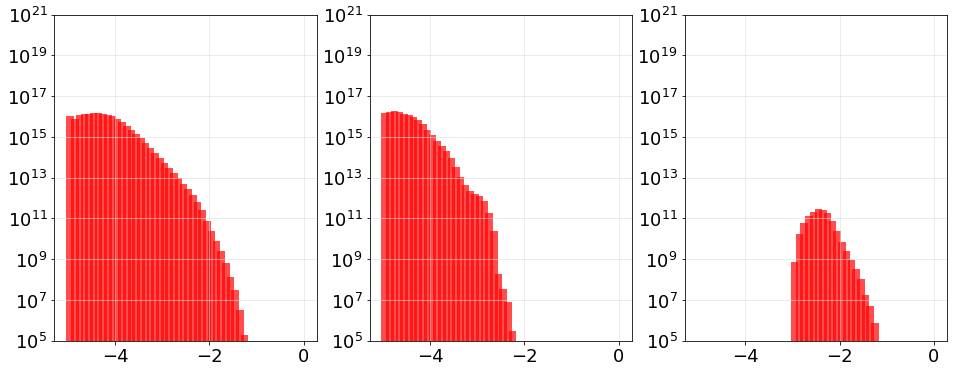

In [62]:
SAVE_FIG = False

N = 50
f_range = np.logspace(-5, 0, 2*N+1, base = 10)
f_plot = np.log10(np.array([f_range[2*i+1] for i in range(N)]))

fig, ax = plt.subplots(1, 3, figsize = (16,6))

# ax[0].bar(f_plot[::2], np.array(totals1), color = "red", width=0.8*width, alpha = 0.7)
ax[0].bar(f_plot, np.array(totals1), color = "red", width=0.8*width, alpha = 0.7)
ax[0].grid(color = "gainsboro", alpha=  0.7)
ax[0].set_yscale('log')
ax[0].set_ylim(10**5, 1e21)

ax[1].bar(f_plot, np.array(totals2), color = "red", width=0.8*width, alpha = 0.7)
ax[1].grid(color = "gainsboro", alpha=  0.7)
ax[1].set_yscale('log')
ax[1].set_ylim(10**5, 1e21)

ax[2].bar(f_plot, np.array(totals3), color = "red", width=0.8*width, alpha = 0.7)
ax[2].grid(color = "gainsboro", alpha=  0.7)
ax[2].set_yscale('log')
ax[2].set_ylim(10**5, 1e21)

if SAVE_FIG:
    fig.savefig("../Output/Figures/number_BWDs_comp.png", dpi = 1000)

plt.show()


### Combination plot

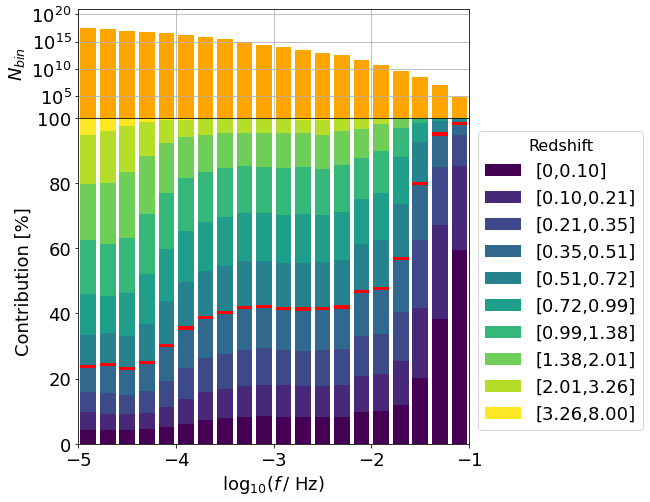

In [12]:
SAVE_FIG = True

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7,8), sharex=True, gridspec_kw={'height_ratios': [1, 3]})

if N == 25:
    ax1.bar(f_plot, np.array(totals1) + np.array(totals2)+np.array(totals3), color = "orange", width=0.8*width)

elif N == 50:
    ax1.bar(f_plot[::2], np.array(totals1) + np.array(totals2)+np.array(totals3), color = "orange", width=0.8*width)

ax1.grid()
ax1.set_yscale('log')
ax1.set_ylim(10**1, 1e21)
ax1.set_ylabel(r"$N_{bin}$")
ax1.set_xlim(-5., -1)

if N == 25:

    width = (f_plot[2]-f_plot[1])

    ax2.bar(f_plot, new_data.iloc[0] + new_data.iloc[1], 
        color = colors(0), label = f"[0,{z_bins[1]:.2f}]", width=0.8*width)
    sum = new_data.iloc[0] + new_data.iloc[1]

elif N==50:

    width = 2*(f_plot[2]-f_plot[1])

    ax2.bar(f_plot[::2], new_data.iloc[0].values[::2] + new_data.iloc[1].values[::2], 
        color = colors(0), label = f"[0,{z_bins[1]:.2f}]", width=0.8*width)
    sum = new_data.iloc[0].values[::2] + new_data.iloc[1].values[::2]

else:
    print(f"Not correctly implemented yet for N = {N}.")

draw_line = False
prev_z_bin = z_bins[1]


for i, z in enumerate(z_bins[3::2]):

    if N == 25:
        props = new_data.iloc[2*i+2] + new_data.iloc[2*i+3]
        ax2.bar(f_plot, props, bottom=sum, color = colors(i+1), label = f"[{prev_z_bin:.2f},{z:.2f}]", width=0.8*width)

    elif N == 50:
        props = new_data.iloc[2*i+2].values[::2] + new_data.iloc[2*i+3].values[::2]
        ax2.bar(f_plot[::2], props, bottom=sum, color = colors(i+1), label = f"[{prev_z_bin:.2f},{z:.2f}]", width=0.8*width)
    
    else: 
        break

    sum = sum + props
    prev_z_bin = z
    if (z >= 0.46) and draw_line == False:
        draw_line = True

        if N == 25:
            ax2.bar(f_plot, np.ones_like(props), bottom=sum, color = "red", width=0.8*width)
        elif N == 25:
            ax2.bar(f_plot[::2], np.ones_like(props), bottom=sum, color = "red", width=0.8*width)

        sum = sum + np.ones_like(props)

ax2.set_xlabel(r"$\log_{10} (f \,/$ Hz)")
ax2.set_ylabel("Contribution [%]")
ax2.set_xlim(-5., -1.)

box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width*0.75, box.height])

box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width*0.75, box.height])
# Put a legend to the right of the current axis
lgd = ax2.legend(loc='center left', bbox_to_anchor=(1., 0.5), title = "Redshift")
ax1.set_yticks([10.**5, 10.**10, 10.**15, 10.**20])
ax1.set_yticklabels([r"$10^{" +f"{i}" + r"}$" for i in [5, 10, 15, 20]])

# plt.tight_layout()

fig.subplots_adjust(hspace = 0)
if SAVE_FIG:
    fig.savefig("../Output/Figures/comb_plot.png", bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 1000)

plt.show()
